**Практика А/В тестирование**

**ЦЕЛЬ:** Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта, необходимо провести A/B-тестирование данных вариантов на предмет эффектинвости новой акции.

In [1]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from scipy.stats import t
from statsmodels.stats import proportion

In [2]:
# загружаем данные
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [4]:
# посмотрим на структуру данных и наличие пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [8]:
# посмотрим на статистику числовых данных
data.describe()

,user_id,purchase,price
count,294478.000000,294478.000000,294478.000000
mean,787974.124733,0.119659,10154.782361
std,91210.823776,0.324563,35153.824872
min,630000.000000,0.000000,0.000000
25%,709032.250000,0.000000,0.000000
50%,787933.500000,0.000000,0.000000
75%,866911.750000,0.000000,0.000000
max,945999.000000,1.000000,200000.000000


In [9]:
# посмотрим на статистику текстовых данных
data.describe(include='object')

,date,group
count,294478,294478
unique,23,2
top,2021-01-08,B
freq,13564,147276


**Выводы:**
- наш датасет состоит из 5 столбцов: пользователь, дата, группа, факт свершения покупки и стоимость тура;
- пропусков в данных нет;
- уникальных дат 23, начаиболее часто встречающаяся 08.01.2021;
- уникальных групп 2, наиболее часто встречается группа B.


In [11]:
# преобразуем дату из текста в формат даты
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


In [84]:
# проверим длительности проведения A/B-тестирования в каждой из групп
data.groupby('group')['date'].agg(['min', 'max', 'nunique'])

,min,max,nunique
group,,,
A,2021-01-02,2021-01-24,23
B,2021-01-02,2021-01-24,23


Длительность проведения A/B-тестирования в каждой из групп совпадает.

In [44]:
# проверим наличие пользователей, которые в процессе A/B-теста попали в обе группы
user_cnt = data.groupby('user_id')['group'].nunique()
user_cnt_more_one = user_cnt[user_cnt > 1]
user_cnt_more_one.head() 

user_id
630320    2
630805    2
630871    2
630887    2
631008    2
Name: group, dtype: int64

In [48]:
print('Количество пользователей, которые попали в обе группы: {}'.format(user_cnt_more_one.count()))

Количество пользователей, которые попали в обе группы: 1895


In [45]:
# удалим пользователей, которые попали в обе группы
data_clear = data[data['user_id'].isin(user_cnt_more_one.index) == False]
data_clear 

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


In [78]:
# рассчитаем вспомогательные показатели для контрольной и тестовой групп
data_group = data_clear.groupby('group').agg(
    {'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}).reset_index().rename(
        columns={'user_id': 'visit', 'purchase': 'purchase_cnt', 'price': 'revenue'})
display(data_group)

,group,visit,purchase_cnt,revenue
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


На основании агрегации на уровне групп можно стказать, что группы А и В в целом сбалансированы, наблюдаются незначительные отклонения в количестве визитов и совершенных покупок.

In [79]:
# рассчитаем ключевые показатели для каждой группы
data_group['conversion'] = data_group['purchase_cnt'] / data_group['visit'] * 100
data_group['avg_check'] = data_group['revenue'] / data_group['visit'] * 100
display(data_group)

,group,visit,purchase_cnt,revenue,conversion,avg_check
0,A,145307,17487,1417780000,12.034520,9.757135e+05
1,B,145381,17290,1533010000,11.892888,1.054478e+06


На основе расчета ключевых показателей можно пронаблюдать, что средний чек в группе В выше, чем в группе А. Конверсия приэтом отличается на незначительную долю %, причем конверсия в группе А выше, чем в группе В. Однозначно сказать, какой из вариантов эффективнее - нельзя.

In [80]:
# сравним варианты A и B по покупательской способности каждого из туров
data_pivot = data_clear[data_clear['price'] > 0].pivot_table(
    index='group',
    columns='price',
    values='purchase',
    aggfunc='sum'
)
data_pivot

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


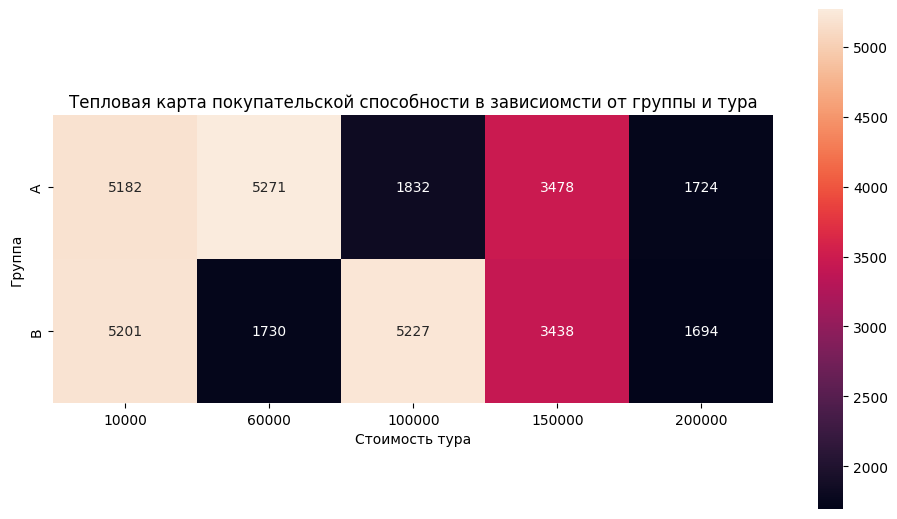

In [81]:
# построим график тепловой карты
fig = plt.figure(figsize=(9, 5)) 
ax = fig.add_axes([1, 1, 1, 1]) 
heat = sns.heatmap(
    data=data_pivot, 
    square=True, 
    annot=True,
    fmt='n')
heat.set_title('Тепловая карта покупательской способности в зависиомсти от группы и тура')
heat.set_xlabel('Стоимость тура')
heat.set_ylabel('Группа');

На основании анализа покупательской способности можно сделать вывод, что для группы А покупательская способность намного выше для туров в Турцию (стоимость тура 60 тыс. руб.), а для группы В -  Таиланд (100 тыс. руб.)

In [83]:
# сгруппируем данные на уровня день/группа и рассчитаем вспомогательные и ключевые метрики
data_group_date = data_clear.groupby(['date', 'group']).agg(
    {'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}).reset_index().rename(
        columns={'user_id': 'visit', 'purchase': 'purchase_cnt', 'price': 'revenue'})
data_group_date['conversion'] = data_group_date['purchase_cnt'] / data_group_date['visit'] * 100
data_group_date['avg_check'] = data_group_date['revenue'] / data_group_date['visit'] * 100
display(data_group_date)

,date,group,visit,purchase_cnt,revenue,conversion,avg_check
0,2021-01-02,A,2854,359,29410000,12.578837,1.030484e+06
1,2021-01-02,B,2861,345,29660000,12.058721,1.036700e+06
2,2021-01-03,A,6596,748,62000000,11.340206,9.399636e+05
3,2021-01-03,B,6619,754,65960000,11.391449,9.965252e+05
4,2021-01-04,A,6566,799,64250000,12.168748,9.785257e+05
5,2021-01-04,B,6536,764,68030000,11.689106,1.040851e+06
6,2021-01-05,A,6433,790,64550000,12.280429,1.003420e+06
7,2021-01-05,B,6511,749,63550000,11.503609,9.760405e+05
8,2021-01-06,A,6606,764,63410000,11.565244,9.598850e+05
9,2021-01-06,B,6751,838,75020000,12.412976,1.111243e+06


In [85]:
# рассчитаем кумулятивные показатели по метрикам
data_group_date['cum_visit'] = data_group_date.groupby(['group'])['visit'].cumsum()
data_group_date['cum_purchase_cnt'] = data_group_date.groupby(['group'])['purchase_cnt'].cumsum()
data_group_date['cum_revenue'] = data_group_date.groupby(['group'])['revenue'].cumsum()

data_group_date['cum_conversion'] = data_group_date['cum_purchase_cnt'] / data_group_date['cum_visit'] * 100
data_group_date['cum_avg_check'] = data_group_date['cum_revenue'] / data_group_date['cum_visit'] * 100
data_group_date.head()

,date,group,visit,purchase_cnt,revenue,conversion,avg_check,cum_visit,cum_purchase_cnt,cum_revenue,cum_conversion,cum_avg_check
0,2021-01-02,A,2854,359,29410000,12.578837,1.030484e+06,2854,359,29410000,12.578837,1.030484e+06
1,2021-01-02,B,2861,345,29660000,12.058721,1.036700e+06,2861,345,29660000,12.058721,1.036700e+06
2,2021-01-03,A,6596,748,62000000,11.340206,9.399636e+05,9450,1107,91410000,11.714286,9.673016e+05
3,2021-01-03,B,6619,754,65960000,11.391449,9.965252e+05,9480,1099,95620000,11.592827,1.008650e+06
4,2021-01-04,A,6566,799,64250000,12.168748,9.785257e+05,16016,1906,155660000,11.900599,9.719031e+05


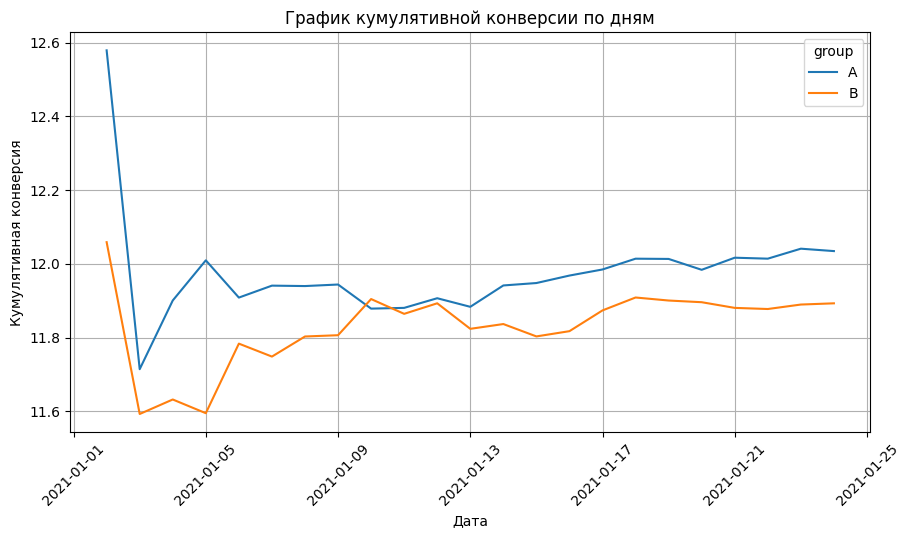

In [90]:
# строим lineplot для кумулятивной конверсии во времени в каждой группе
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=data_group_date, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.set_xlabel('Дата')
ax.set_ylabel('Кумулятивная конверсия')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

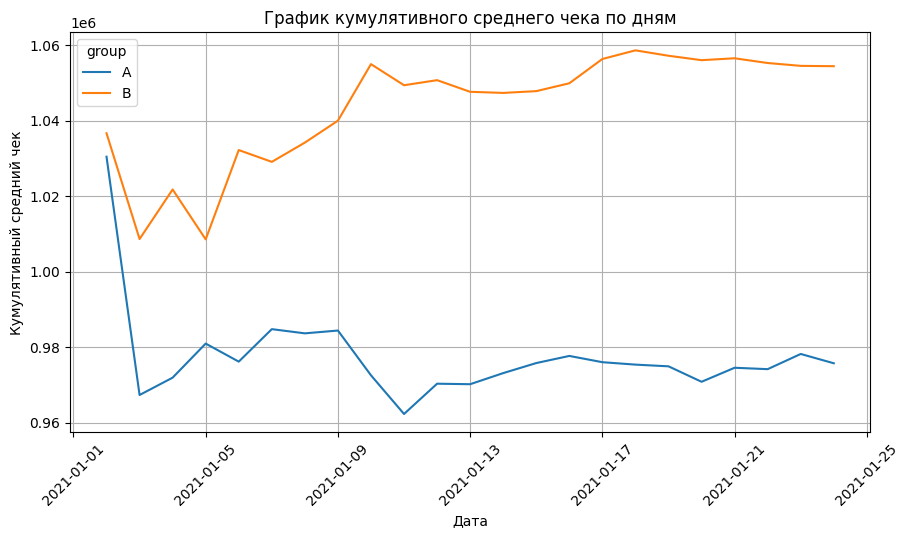

In [91]:
# строим lineplot для кумулятивного среднего чека во времени в каждой группе
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_avg_check', data=data_group_date, hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
ax.set_xlabel('Дата')
ax.set_ylabel('Кумулятивный средний чек')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

Согласно графиков можем наблюдать стабилизацию метрик после 10.01.2021 г. Как на базовых метриках, так и на кумулятивных видно, что конверсия выше в группе А, а средний чек выше в группе B.

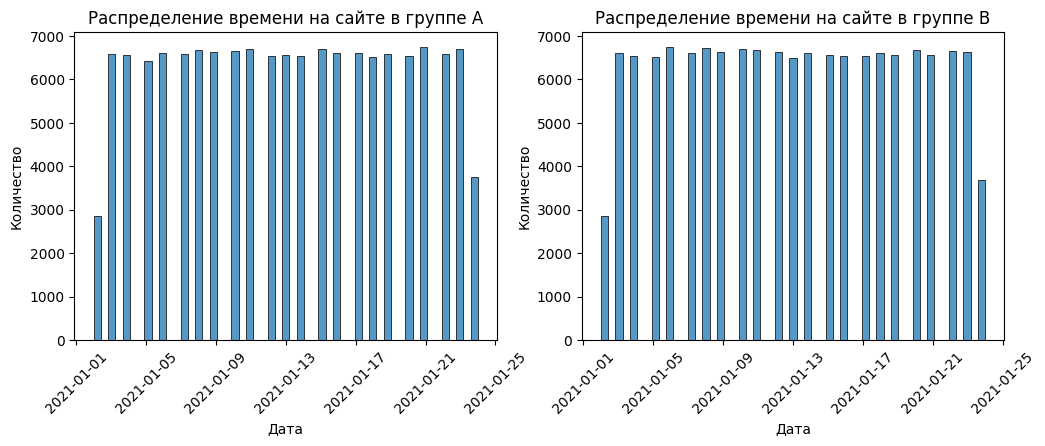

In [131]:
# построим гистограммы  для проверки на нормальность
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='date', data=data_clear[data_clear['group'] == 'A'], ax=axes[0])
axes[0].xaxis.set_tick_params(rotation = 45)
axes[0].set_title('Распределение времени на сайте в группе А');
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Количество')
sns.histplot(x='date', data=data_clear[data_clear['group'] == 'B'], ax=axes[1])
axes[1].set_title('Распределение времени на сайте в группе B')
axes[1].xaxis.set_tick_params(rotation = 45)
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество');
 

На грфаиках видно, что данные не распределены нормально. Дополнительно проведем тест Шапиро-Уилка для закрепления результата визуализации.

In [115]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(data_clear[data_clear['group'] == 'A'].groupby('date')['date'].count().values)
shapiro_result_b = shapiro(data_clear[data_clear['group'] == 'B'].groupby('date')['date'].count().values)
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.0
p-value группы B 0.0
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального


Сформируем 2 гипотезы, которые потребуется проверить:
- наличие статистической разницы между конверсиями в группах А и B:
    - ($H_0$): статистической разницы между конверсиями нет;
    - ($H_1$): статистическая разница между конверсиями присутствует;
- наличие статистической разницы между ежедневными средними чеками в группах А и B:
    - ($H_0$): статистической разницы между средними чеками нет;
    - ($H_1$): статистическая разница между средними чеками присутствует.
  
Для конверсии будем использовать Z-тест для пропорций и Chi-тест.   
Для среднего чека: у нас 2 независимы группы, и данные в них не рапсределны нормально, соответственно необходимо использовать U-критерий Манна-Уитни

In [116]:
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=data_group['purchase_cnt'],
    nobs=data_group['visit'], 
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


In [117]:
# вычисляем значение p-value для Chi-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=data_group['purchase_cnt'],
    nobs=data_group['visit']
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


Оба теста в результате показали, что отсутствует статистическая значимость разницы конверсий между группами А и В.

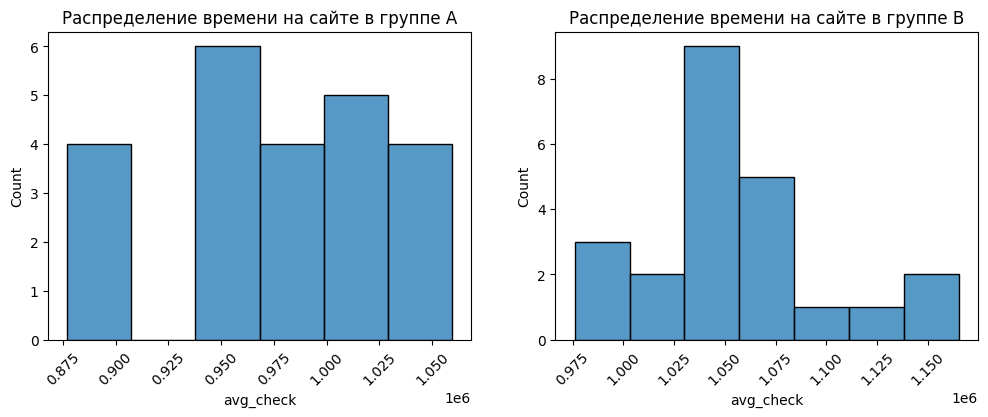

In [133]:
# построим гистограммы  для проверки на нормальность
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='avg_check', data=data_group_date[data_group_date['group'] == 'A'], ax=axes[0])
axes[0].xaxis.set_tick_params(rotation = 45)
axes[0].set_title('Распределение времени на сайте в группе А');
sns.histplot(x='avg_check', data=data_group_date[data_group_date['group'] == 'B'], ax=axes[1])
axes[1].set_title('Распределение времени на сайте в группе B')
axes[1].xaxis.set_tick_params(rotation = 45);
 

In [127]:
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(data_group_date[data_group_date['group'] == 'A']['avg_check'])
shapiro_result_b = shapiro(data_group_date[data_group_date['group'] == 'B']['avg_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.22
p-value группы B 0.2
Принимаем нулевую гипотезу. Распределение в группе А является нормальным
Принимаем нулевую гипотезу. Распределение в группе B является нормальным


In [121]:
# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=data_group_date[data_group_date['group'] == 'A']['avg_check'],
    y=data_group_date[data_group_date['group'] == 'B']['avg_check'],
    alternative='less' 
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


In [129]:
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=data_group_date[data_group_date['group'] == 'A']['avg_check'],
    b=data_group_date[data_group_date['group'] == 'B']['avg_check'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


По результатам анализа, можно наблюдать, что существует статистическая значимость разницы между средними чеками в группах А и В.

In [135]:
# разделим данные на группы для подсчета доверительных интервалов
group_a = data_group_date[data_group_date['group'] == 'A']['avg_check']
group_b = data_group_date[data_group_date['group'] == 'B']['avg_check']

In [141]:
# соберем 95 %  доверительные интервалы для ежедневного среднего чека для групп А и В при неизвестном стандартном отклонении

n_a = group_a.count() # размер выборки
k_a = n_a - 1 # число степеней свободы
x_mean_a = group_a.mean() # выборочное среднее
x_std_a = group_a.std() # выборочное стандартное отклонение
gamma_a = 0.95 # уровень надёжности
alpha_a = 1 - gamma_a # уровень значимости

lower, upper = t.interval(gamma_a, df=k_a, loc=x_mean_a, scale=x_std_a/(n_a ** 0.5))
print('Доверительный интервал для среднего чека группы A: {}'.format((round(lower), round(upper))))

Доверительный интервал для среднего чека группы A: (952710, 997936)


In [142]:
n_b = group_b.count() # размер выборки
k_b = n_b - 1 # число степеней свободы
x_mean_b = group_b.mean() # выборочное среднее
x_std_b = group_b.std() # выборочное стандартное отклонение
gamma_b = 0.95 # уровень надёжности
alpha_b = 1 - gamma_b # уровень значимости

lower, upper = t.interval(gamma_b, df=k_b, loc=x_mean_b, scale=x_std_b/(n_b ** 0.5))
print('Доверительный интервал для среднего чека группы В: {}'.format((round(lower), round(upper))))

Доверительный интервал для среднего чека группы В: (1034281, 1073432)


Доверительные интервалы по итогу анализа не пересекаются, что говорит о том, что мы на 95 % уверены, что средний чек в группе В действительно выше среднего чека в группе А.

In [148]:
# вычисляем доверительный интервал для конверсии в группе A с уровнем доверия 95%
low_a, up_a = proportion.proportion_confint(
    count=data_group[data_group['group'] == 'A']['purchase_cnt'].values[0],
    nobs=data_group[data_group['group'] == 'A']['visit'].values[0],
    alpha=0.05
)

# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(low_a * 100, 2), round(up_a * 100, 2))))

Доверительный интервал для конверсии в группе А: (11.87, 12.2)


In [149]:
# вычисляем доверительный интервал для конверсии в группе B с уровнем доверия 95%
low_a, up_a = proportion.proportion_confint(
    count=data_group[data_group['group'] == 'B']['purchase_cnt'].values[0],
    nobs=data_group[data_group['group'] == 'B']['visit'].values[0],
    alpha=0.05
)

# выводим результат
print('Доверительный интервал для конверсии в группе B: {}'.format((round(low_a * 100, 2), round(up_a * 100, 2))))

Доверительный интервал для конверсии в группе B: (11.73, 12.06)


In [151]:
# напишем функцию доверительного интервала для разности пропорций
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [154]:
# построим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(
    x_p=[data_group[data_group['group'] == 'A']['conversion'].values[0] / 100, 
         data_group[data_group['group'] == 'B']['conversion'].values[0] / 100], 
    n=[data_group[data_group['group'] == 'A']['visit'].values[0], data_group[data_group['group'] == 'B']['visit'].values[0]])

# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Доверительный интервал для разности конверсий имеет левую отрицательную и правую положительную границы, что говорит о том, что с 95% вероятностью группы А и В равнозначны по метрике конверсии. 

**В результате проведения А/В-тестирования мы получили следующие результаты:**
- анализ метрики конверсия различнымим тестами показал, что отсутствует статистическая значимость разницы конверсии между группами А и В, то есть новый вариант посадочной страницы не увеличил колиечство покупок;
- анализ метрики среднего чека различнымим тестами показал, что есть статистическая значимость разницы среднего чека между группами А и В, то есть новый вариант посадочной страницы принес положительный эффект. Это было отображено на кумулятивных графиках, протестировано на статистических тестах и в результате построения доверительных интервалов для метрики.
- итого можно сказать, что даже если не изменилась конверсия при новом варианте посадочной страницы, то средний чек при этом вырос, что говорит об эффективности примененных изменений.